In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
import sklearn.gaussian_process.kernels as k
from scipy.interpolate import interp1d
from tqdm import tqdm
from astroML.utils import split_samples

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
pip install pyarrow

  Using cached pyarrow-16.1.0-cp39-cp39-manylinux_2_28_x86_64.whl (40.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
def plot_timeseries(df: pd.DataFrame, indx=0 ) -> None:
    '''Plot the generated time series data.
        Args:
            df: Pandas DataFrame with the generated data
            indx: index of the time series to plot
        '''
    df[f'y{indx}' ].plot(style='o')  

    plt.show()

In [50]:
def plottingFits(x, y, x_pred, y_pred, x_model, y_model, sigma, fit_unc):
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, label='Data')
    plt.plot(x_model, y_model, c='r')
    #plt.plot(x_pred, y_pred, 'b-', label='Prediction with GP')
    plt.fill_between(
        x_model,
        y_model - (1.96 * fit_unc),
        y_model + (1.96 * fit_unc),
        alpha=0.3,
        label="95% confidence interval(GP)"
    )
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.legend()
    return(plt.show())

In [51]:
def data_read(data_type, image_number = 20):
    
    if (data_type == 'plasticc'):
        
        plasticc_metadata = pd.read_pickle('Project data/plasticc_lightcurves_g_metadata.pkl')
        with open('Project data/plasticc_lightcurves_g.pkl', 'rb') as file:
            plasticc_LC = pickle.load(file)

        tSeries = plasticc_LC[plasticc_metadata['object_id'].iloc[image_number]].index.values
        intensity_data = plasticc_LC[plasticc_metadata['object_id'].iloc[image_number]].values
        y_true = plasticc_metadata['true_target'].iloc[image_number]
        return(np.array(tSeries), intensity_data, y_true)
    
    if(data_type == 'plasticc_test'):
        lcs = []
        plasticc_metadata = pd.read_pickle('Project data/plasticc_lightcurves_g_metadata.pkl')
        with open('Project data/plasticc_lightcurves_g.pkl', 'rb') as file:
            plasticc_LC = pickle.load(file)
            
        y_true = plasticc_metadata['true_target'].iloc[:].values

        for i in tqdm(range(len(plasticc_metadata))):
            try:
                lc = (np.array([(plasticc_LC[plasticc_metadata['object_id'].iloc[i]].index).values, plasticc_LC[plasticc_metadata['object_id'].iloc[i]].values]).T).tolist()
                lcs.append(lc)
            except KeyError:
                continue
        return(lcs, y_true)
    
    else:
        if (data_type == 'single'):
            df = pd.read_feather("Project data/timeseries_single_frequency.feather")

        elif (data_type == 'multiple'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency.feather")

        elif (data_type == 'multiple_sampled'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency_sampled.feather")
    
        tSeries = df['y50']
        time_range = tSeries.axes[0].tolist()
        intensity_data = tSeries.values
    
        return(np.array(time_range), intensity_data)

In [6]:
def pointPrediction(new_fit, n_pred, x, y):
    delta_t = x[-1] - x[-2]
    x_pred = (np.array([range(1, 1 + n_pred)]).T)*delta_t + x[-1]
    
    return(x_pred, *new_fit.predict(x_pred, return_std = True))

In [55]:
def gaussianProcess_fitting(x, y, kernel, n_pred):
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=90)
    gp.fit(x, y)
    optimizedParams = gp.kernel_
    
    x_pred, y_pred, sigma = pointPrediction(gp, n_pred, x, y)
    
    #x_model = np.concatenate([x, x_pred])
    x_model = np.linspace(min(x), max(x_pred), 100)
    y_model, fit_unc = gp.predict(x_model, return_std=True)
    
    return(x_pred, y_pred, sigma, optimizedParams, x_model, y_model, fit_unc)

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  6.39**2 * RBF(length_scale=22.1)


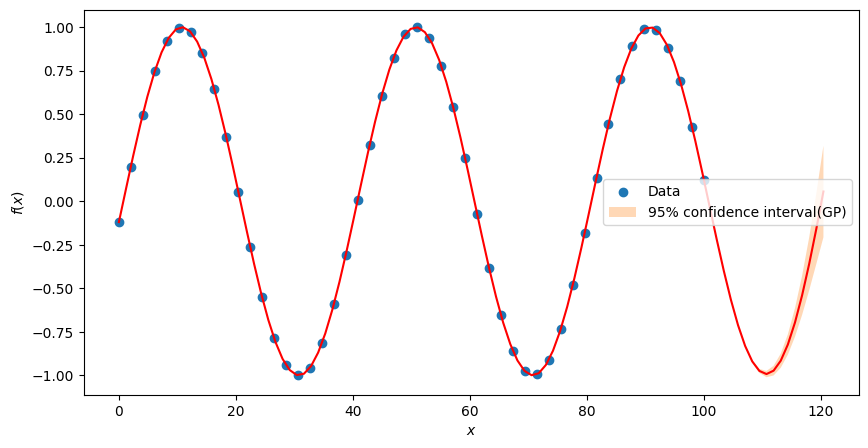

In [29]:
x, y = data_read('single')
x_true = x
x = x.reshape(-1,1)
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc)

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  4.74**2 * RBF(length_scale=40.6)


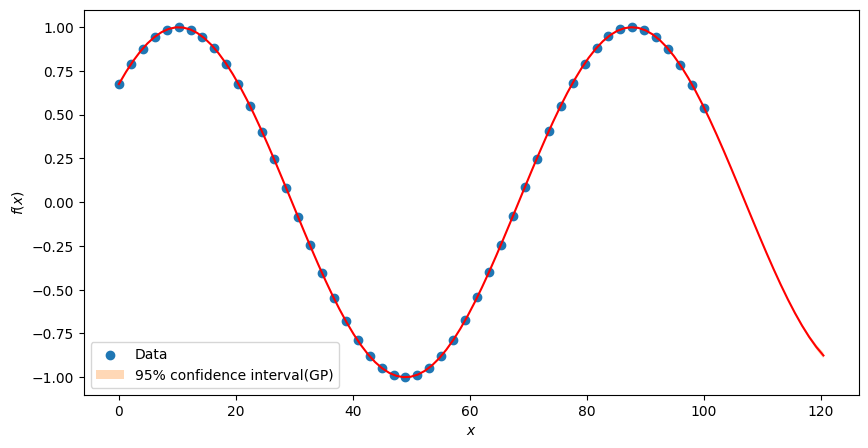

In [31]:
x, y = data_read('multiple')
x_true = x
x = x.reshape(-1,1)

n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc)

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  4.59**2 * RBF(length_scale=40.1)


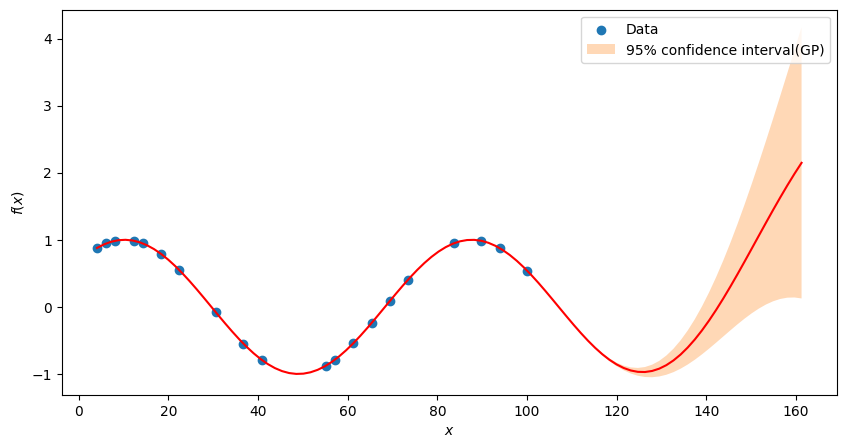

In [57]:
x, y = data_read('multiple_sampled')
x_true = x
x = x.reshape(-1,1)
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc.flatten())

Optimized hyper parameters:  46.9**2 * RBF(length_scale=7.36)


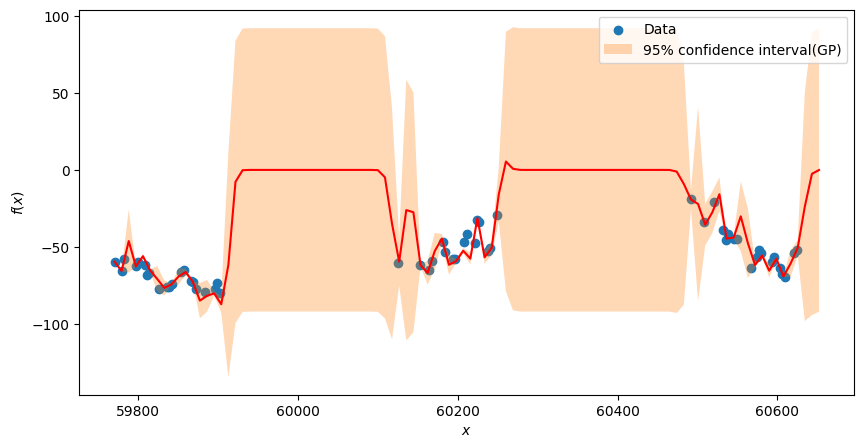

88


In [59]:
x, y, type_true = data_read('plasticc', image_number = 5)
x_true = x
x = x.reshape(-1,1)
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_pred, y_pred, x_model.flatten(), y_model.flatten(), sigma, fit_unc)
print(type_true)

In [18]:
def RNN_fitting(lcs, y, n_pred):
    
    y_map = list(range(len(np.unique(y))))
    y_types = np.unique(y)
    mapping_dict = {value: y_map[index] for index, value in enumerate(y_types)}
    y_adj = [mapping_dict[value] for value in y]
    n_class = len(y_types)
    y_cat = keras.utils.to_categorical(y_adj)
    
    
    (X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(lcs, y_cat, [0.8, 0.1, 0.1], random_state=0)

    
    model = keras.Sequential([
    layers.Input(np.shape(lcs[0])),
    layers.GRU(16, return_sequences=True),
    layers.GRU(8),
    layers.Dense(n_class, activation='softmax')
    ])

    model.summary()

    model.compile(
        # Optimizer
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        # Loss function to minimize
        loss=keras.losses.CategoricalCrossentropy(),
        # List of metrics to monitor
        metrics=[keras.metrics.CategoricalAccuracy()],
    )

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=5,
            verbose=1,
            min_delta=1e-4,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=10,
            verbose=1,
        )
    ]

    history = model.fit(X_train,
        y_train,
        batch_size=128,
        epochs=100,
        validation_data=(X_valid, y_valid),
        callbacks=callbacks
    )

    pred_proba = model.predict(X_test)
    pred_class = np.argmax(pred_proba, axis=1)

    fig = plt.figure(figsize=(17,4))
    ax = plt.subplot(1,3,1)
    ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, xticks_rotation=45)
    plt.title('counts')
    ax = plt.subplot(1,3,2)
    ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, normalize='true', values_format='.3f',  xticks_rotation=45)
    plt.title('normalized by true label')
    ax = plt.subplot(1,3,3)
    ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), pred_class, cmap='Blues', ax=ax, normalize='pred', values_format='.3f', xticks_rotation=45)
    plt.title('normalized by prediction')
    plt.show()
    return(plt.show)

In [16]:
def lf_processing(lcs):
    time_sample = np.zeros((len(lcs), 50))
    lc_sample = np.zeros((len(lcs), 50))

    for i, lc in enumerate(lcs):
        lc = np.asarray(lc)
        lc_timing = lc[:,0]
        lc_flux = lc[:,1]
        spl = interp1d(lc_timing, lc_flux, kind='cubic', fill_value= 'extrapolate')
        time_range = np.linspace(min(lc_timing), max(lc_timing), 50)
        processed_lc = spl(time_range)
        time_sample[i] = time_range
        lc_sample[i] = processed_lc
        
    return(lc_sample, time_sample)

100%|██████████| 1135/1135 [00:00<00:00, 28715.29it/s]
2024-05-21 23:49:52.312150: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 2, 16)             3264      
                                                                 
 gru_1 (GRU)                 (None, 8)                 624       
                                                                 
 dense (Dense)               (None, 13)                117       
                                                                 
Total params: 4,005
Trainable params: 4,005
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 6s 147ms/step - loss: 2.4508 - categorical_accuracy: 0.1619 - val_loss: 2.2796 - val_categorical_accuracy: 0.1504 - lr: 0.0100
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 2.2050 - categorical_accuracy: 0.2236 - val_loss: 2.1428 - val_categ

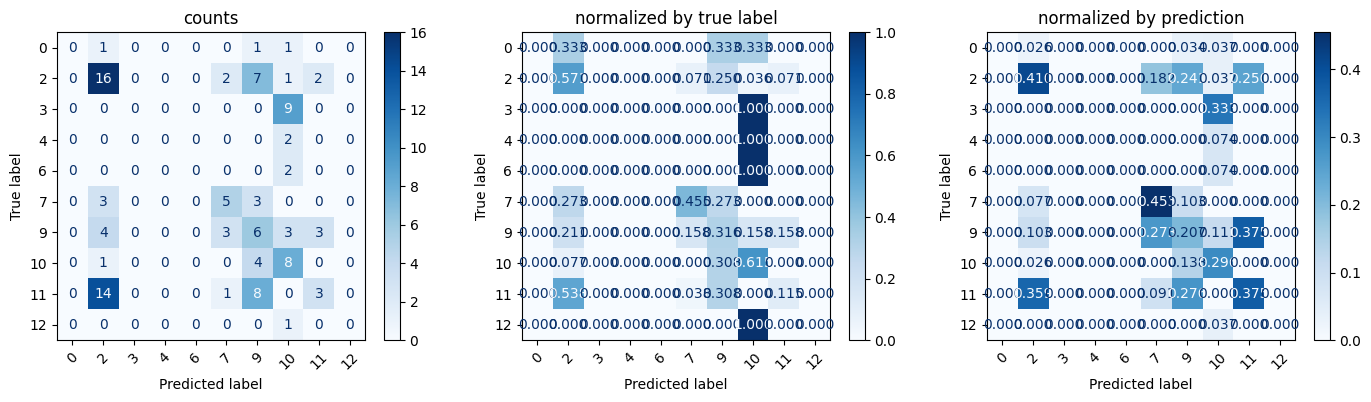

Optimized hyper parameters:  35**2 * RBF(length_scale=8.63)


NameError: name 'x_test' is not defined

In [17]:
lc_test, type_true = data_read('plasticc_test', image_number = 20)
lc_test = np.transpose((lf_processing(lc_test)), (1, 0, 2))

n_points = 10

RNN = RNN_fitting(lc_test, type_true, 10)

print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x_test, y_test, x_pred, y_pred, sigma)
#print(type_true)